In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import struct

import utils as u
from visualization import papermode
from visualization import can_viz as canv

papermode(plt, size=18)


In [2]:
abbr = "S23"
filename = u.get_filename(abbr)
basename = u.get_basename(filename)
datadir = u.get_rundir(basename)

elec_data_path = datadir / "elec"
odom_data_path = datadir / "odom"
temp_data_path = datadir / "temp"
imu_data_path = datadir / "imu"
can_path = u.find_canlog(datadir)

figdir = u.get_figdir("thesis", subdir="data-processing/warthog-canbus")


In [3]:
mcu_path = elec_data_path / f"{basename}_elec_mcu_status.csv"
IL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_current.csv"
IR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_current.csv"
VL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_voltage.csv"
VR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_voltage.csv"
wL_path = odom_data_path / f"{basename}_odom_left_drive_status_speed.csv"
wR_path = odom_data_path / f"{basename}_odom_right_drive_status_speed.csv"

imuodom_path = imu_data_path / f"{basename}_imu_imu_and_wheel_odom.csv"


heatL_path = temp_data_path / f"{basename}_temp_left_drive_status_heatsink_temperature.csv"
heatR_path = temp_data_path / f"{basename}_temp_right_drive_status_heatsink_temperature.csv"
motorL_path = temp_data_path / f"{basename}_temp_left_drive_status_motor_temperature.csv"
motorR_path = temp_data_path / f"{basename}_temp_right_drive_status_motor_temperature.csv"


IL_df = pd.read_csv(IL_path)
IR_df = pd.read_csv(IR_path)
wL_df = pd.read_csv(wL_path)
wR_df = pd.read_csv(wR_path)
VL_df = pd.read_csv(VL_path)
VR_df = pd.read_csv(VR_path)
mcu_df = pd.read_csv(mcu_path)
mcu_df = mcu_df[["time", "/mcu/status/current_battery", "/mcu/status/measured_battery"]].copy()

imu_df = pd.read_csv(imuodom_path)
imu_df = imu_df[["time", "/imu_and_wheel_odom/lin_twi/x", "/imu_and_wheel_odom/position/z"]].copy()


IL_df = IL_df.rename(columns={"/left_drive/status/battery_current": "IL"})
IR_df = IR_df.rename(columns={"/right_drive/status/battery_current": "IR"})
VL_df = VL_df.rename(columns={"/left_drive/status/battery_voltage": "VL"})
VR_df = VR_df.rename(columns={"/right_drive/status/battery_voltage": "VR"})
wL_df = wL_df.rename(columns={"/left_drive/status/speed": "wL"})
wR_df = wR_df.rename(columns={"/right_drive/status/speed": "wR"})
mcu_df = mcu_df.rename(columns={"/mcu/status/current_battery": "iBatt", "/mcu/status/measured_battery": "vBatt"})

imu_df = imu_df.rename(columns={"/imu_and_wheel_odom/lin_twi/x": "vx", "/imu_and_wheel_odom/position/z": "pz"})

heatL_df = pd.read_csv(heatL_path)
heatR_df = pd.read_csv(heatR_path)
motorL_df = pd.read_csv(motorL_path)
motorR_df = pd.read_csv(motorR_path)
heatL_df = heatL_df.rename(columns={"/left_drive/status/heatsink_temperature": "hL"})
heatR_df = heatR_df.rename(columns={"/right_drive/status/heatsink_temperature": "hR"})
motorL_df = motorL_df.rename(columns={"/left_drive/status/motor_temperature": "mL"})
motorR_df = motorR_df.rename(columns={"/right_drive/status/motor_temperature": "mR"})

In [4]:
imu_df.head()

time            vx            pz
0  1.660338e+09  6.142268e-15 -9.297473e-15
1  1.660338e+09  6.142268e-15 -9.314595e-15
2  1.660338e+09  6.142268e-15 -9.314595e-15
3  1.660338e+09  6.142268e-15 -9.314595e-15
4  1.660338e+09  6.142268e-15 -9.314595e-15

In [5]:
time_min_odom = min(wL_df.time.min(), wR_df.time.min())
time_min_elec = min(IL_df.time.min(), IR_df.time.min())
time_min = min(time_min_elec, time_min_odom)

time_max_odom = max(wL_df.time.max(), wR_df.time.max())
time_max_elec = max(IL_df.time.max(), IR_df.time.max())
time_max = max(time_max_elec, time_max_odom)

reltime_max = time_max - time_min

In [6]:
can_df = u.read_canlog(can_path)
canL_df = can_df[can_df.frameID == '501'].copy()
canR_df = can_df[can_df.frameID == '502'].copy()

canL_df["packet"] = canL_df.can_packet.str[4:]
canR_df["packet"] = canR_df.can_packet.str[4:]

u.decompose_packet(canL_df, "packet")
u.decompose_packet(canR_df, "packet")

canL_df.to_csv(datadir / "elec" / f"{basename}_elec_canL.csv", index=False)
canR_df.to_csv(datadir / "elec" / f"{basename}_elec_canR.csv", index=False)

In [7]:
IL_df["time_rel"] = IL_df.time - time_min
IR_df["time_rel"] = IR_df.time - time_min
VL_df["time_rel"] = VL_df.time - time_min
VR_df["time_rel"] = VR_df.time - time_min
wL_df["time_rel"] = wL_df.time - time_min
wR_df["time_rel"] = wR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min
mcu_df["time_rel"] = mcu_df.time - time_min

heatL_df["time_rel"] = heatL_df.time - time_min
heatR_df["time_rel"] = heatR_df.time - time_min
motorL_df["time_rel"] = motorL_df.time - time_min
motorR_df["time_rel"] = motorR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min

imu_df["time_rel"] = imu_df.time - time_min


In [8]:
canL_mask = (canL_df.time_rel > 0) & (canL_df.time < time_max)
canL_df = canL_df[canL_mask].copy().reset_index(drop=True)

canR_mask = (canR_df.time_rel > 0) & (canR_df.time < time_max)
canR_df = canR_df[canR_mask].copy().reset_index(drop=True)

mcu_mask = (mcu_df.time_rel > 0) & (mcu_df.time < time_max)
mcu_df = mcu_df[mcu_mask].copy().reset_index(drop=True)

imu_mask = (imu_df.time_rel > 0) & (imu_df.time < time_max)
imu_df = imu_df[imu_mask].copy().reset_index(drop=True)

# Downhill

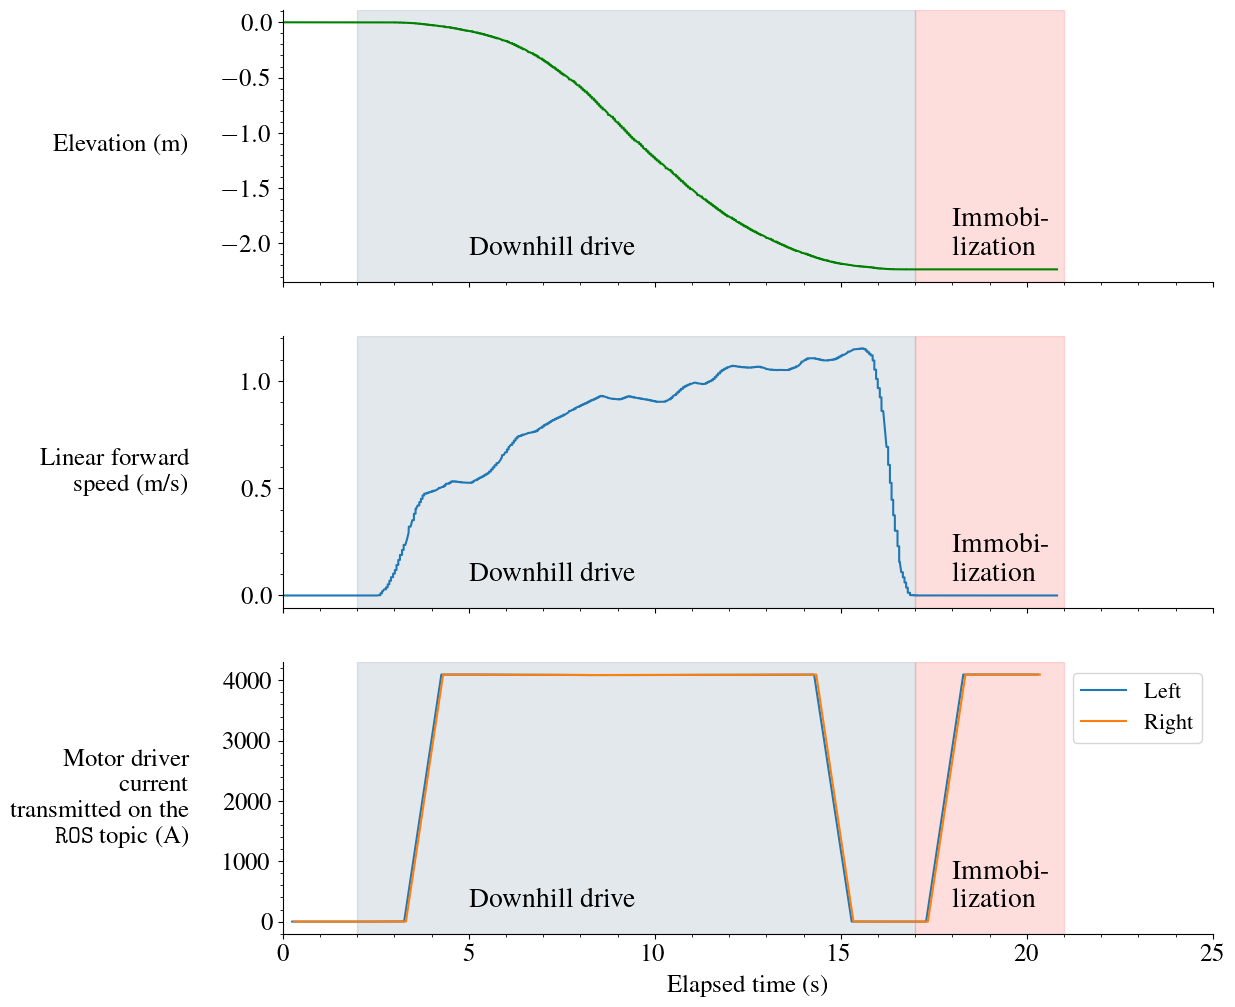

In [42]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=3, sharex=True)

axs[0].plot(imu_df.time_rel, imu_df.pz, "g")
axs[0].set_ylabel("Elevation (m)", rotation=0, ha="right", va="center")
axs[0].yaxis.set_label_coords(-0.1, 0.5)

axs[1].plot(imu_df.time_rel, imu_df.vx)
axs[1].set_ylabel("Linear forward\nspeed (m/s)", rotation=0, ha="right", va="center")
axs[1].yaxis.set_label_coords(-0.1, 0.5)

axs[2].plot(IL_df.time_rel, IL_df.IL, label="Left")
axs[2].plot(IR_df.time_rel, IR_df.IR, label="Right")
axs[2].set_ylabel(
    "Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)",
    rotation=0,
    ha="right",
    va="center",
)
axs[2].yaxis.set_label_coords(-0.1, 0.5)

axs[2].legend(fontsize=16)
axs[2].set_xlabel("Elapsed time (s)")
axs[2].xaxis.set_label_coords(0.5, -0.15)
axs[2].set_xlim(left=0, right=25)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

    # ax.axvline(x=2, color="xkcd:blue/grey", linestyle="--")
    # ax.axvline(x=17, color="xkcd:blue/grey", linestyle="--")
    # ax.axvline(x=21, color="xkcd:blue/grey", linestyle="--")
    ax.axvspan(2,17, color="xkcd:blue/grey", alpha=0.2)
    ax.axvspan(17,21, color="xkcd:coral", alpha=0.2)
    ax.annotate("Downhill drive", xy=(0.2,0.1), xycoords='axes fraction', fontsize=20)
    ax.annotate("Immobi-\nlization", xy=(0.72,0.1), xycoords='axes fraction', fontsize=20)

# axs[0].axvline(x=3)
# axs[1].axvline(x=3)
# axs[2].axvline(x=3)

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-downhill.{ext}", bbox_inches="tight")


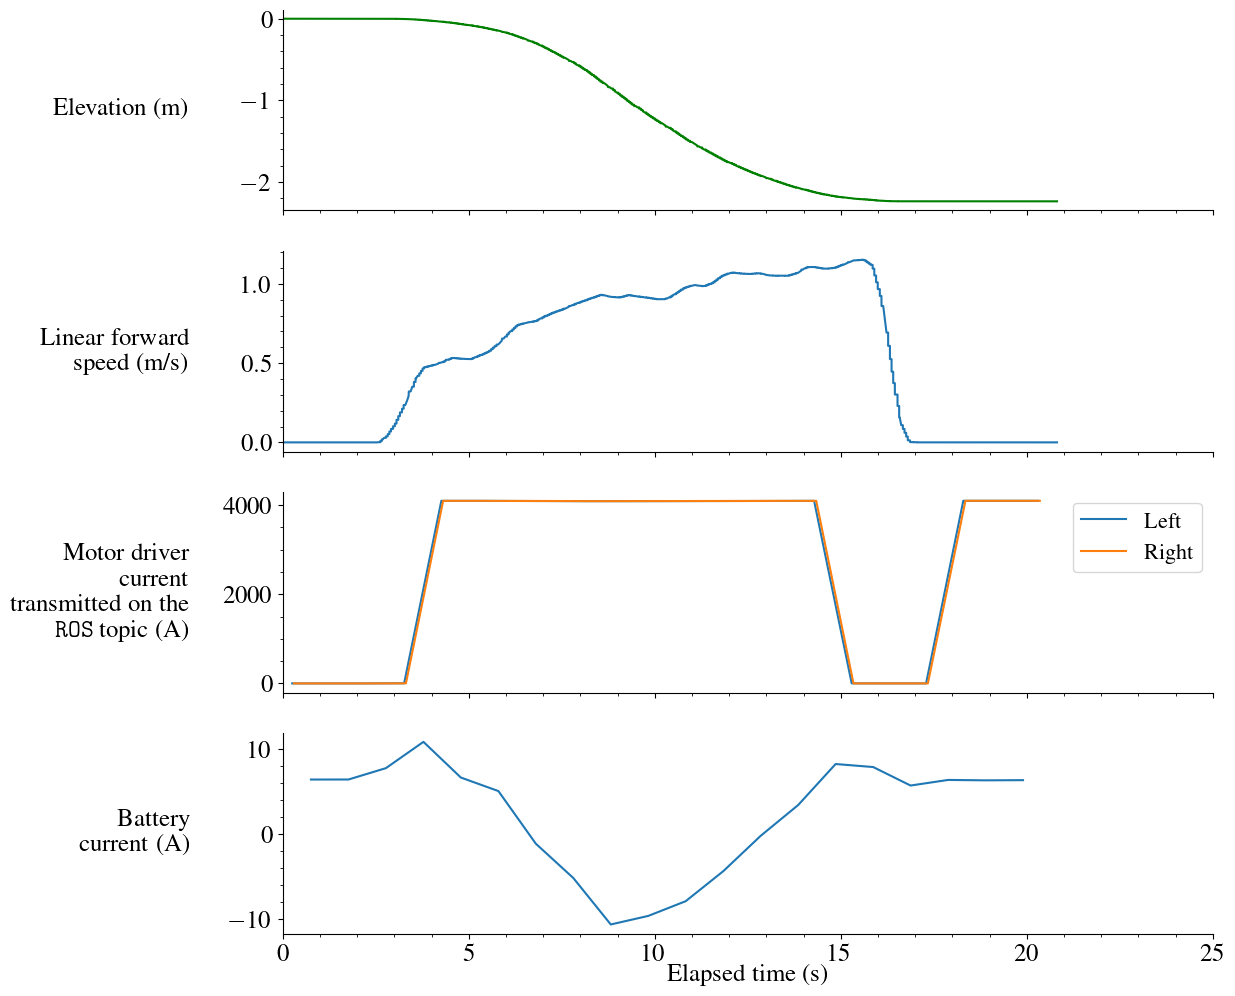

In [10]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=4, sharex=True)

axs[0].plot(imu_df.time_rel, imu_df.pz, "g")
axs[0].set_ylabel("Elevation (m)", rotation=0, ha="right", va="center")
axs[0].yaxis.set_label_coords(-0.1, 0.5)

axs[1].plot(imu_df.time_rel, imu_df.vx)
axs[1].set_ylabel("Linear forward\nspeed (m/s)", rotation=0, ha="right", va="center")
axs[1].yaxis.set_label_coords(-0.1, 0.5)

axs[2].plot(IL_df.time_rel, IL_df.IL, label="Left")
axs[2].plot(IR_df.time_rel, IR_df.IR, label="Right")
axs[2].set_ylabel(
    "Motor driver\ncurrent\ntransmitted on the\n\\texttt{ROS} topic (A)",
    rotation=0,
    ha="right",
    va="center",
)
axs[2].yaxis.set_label_coords(-0.1, 0.5)
axs[2].legend(fontsize=16)

axs[3].plot(mcu_df.time_rel, mcu_df.iBatt)
axs[3].set_ylabel("Battery\ncurrent (A)", rotation=0, ha="right", va="center")
axs[3].yaxis.set_label_coords(-0.1, 0.5)

axs[3].set_xlabel("Elapsed time (s)")
axs[3].xaxis.set_label_coords(0.5, -0.15)
axs[3].set_xlim(left=0, right=25)

for ax in axs:
    ax.spines[["right", "top"]].set_visible(False)
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

for ext in u.EXTS:
    fig.savefig(figdir / f"warthog-downhill-battery.{ext}", bbox_inches="tight")